In [13]:
import torch
import torchvision
from torchvision.transforms import Resize, Normalize
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from skimage import io

# https://unsplash.com/photos/kVg0VxL1DtU
url = "https://images.unsplash.com/photo-1488842817413-6e197d6d8d53?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1510&q=80"
io.imsave("Christopher Campbell Unsplash.jpg", io.imread(url))

def load_image(file_path, scale_factor = 0.5, normalize = False):
    try:
        image = torchvision.io.read_image(file_path)
        image = image.to(torch.float32) / 255
        height = image.shape[1]
        width = image.shape[2]
        resize = Resize([int(height * scale_factor), int(width * scale_factor)])
        image = resize(image).unsqueeze(0)
        if normalize == True:
            normalize = Normalize(mean = (0.485, 0.456, 0.406), 
                                  std = (0.229, 0.224, 0.225))
            image = normalize(image)
        return image
    except:
        return None

In [14]:
# Original code from:
# https://debuggercafe.com/instance-segmentation-with-pytorch-and-mask-r-cnn/
# heavily modified to the needs of this notebook.

COCO_INSTANCE_CATEGORY_NAMES = np.array([
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
])

def get_object_detections(model, image, threshold = 0.5):
    with torch.no_grad():
        outputs = model(image)[0]

    _scores = outputs["scores"].detach().numpy()
    _labels = COCO_INSTANCE_CATEGORY_NAMES[outputs["labels"].detach().numpy()]
    want = (_scores > threshold) #& (_labels == "person")
    scores = _scores[want].tolist()

    boxes = outputs["boxes"].detach().numpy()[want].tolist()
    labels = _labels[want].tolist()
    if "masks" in outputs.keys():
        masks = outputs["masks"].detach().numpy()[want].tolist()
    else:
        masks = []
        
    masks = np.array(masks)
    boxes = np.round(boxes).astype(int)
    labels = np.array(labels)
    scores = np.array(scores)
        
    return boxes, labels, scores, masks

def draw_segmentation_map(image, boxes, labels, scores, masks, alpha = 1, beta = 0.6, gamma = 0):
    COLORS = np.random.uniform(0, 255, size = (len(COCO_INSTANCE_CATEGORY_NAMES), 3)) / 255

    image = image.numpy().squeeze().transpose(1, 2, 0)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    for i in range(len(scores)):
        color = COLORS[random.randrange(0, len(COLORS))]
        if len(masks) > 0:
            _masks = masks[i].squeeze()
            red_map = _masks.reshape([*_masks.shape, 1]) * color[0]
            green_map = _masks.reshape([*_masks.shape, 1]) * color[1]
            blue_map = _masks.reshape([*_masks.shape, 1]) * color[2]
            segmentation_map = np.stack([red_map, green_map, blue_map], axis = 2).squeeze().astype(image.dtype)

            cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)

        if len(boxes) > 0:
            cv2.rectangle(image, (boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3]), color = color, thickness = 5)

        cv2.putText(image , "{} : {:.2f}%.".format(labels[i], scores[i] * 100), (boxes[i][0], boxes[i][1] - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color = color, thickness = 5, lineType = cv2.LINE_AA)
    
        image[image > 1] = 1
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [16]:
det_model = fasterrcnn_resnet50_fpn(pretrained = True, progress = True, 
                                    num_classes = 91, pretrained_backbone = True, 
                                    trainable_backbone_layers = None)
det_model.eval()

file_path = "Christopher Campbell Unsplash.jpg"

image = load_image(file_path = file_path, scale_factor = 0.75)

print(np.shape(image))

torch.Size([1, 3, 722, 1132])


In [24]:
boxes, labels, scores, masks = get_object_detections(det_model, image, 0.9)
img = draw_segmentation_map(image, boxes, labels, scores, masks)

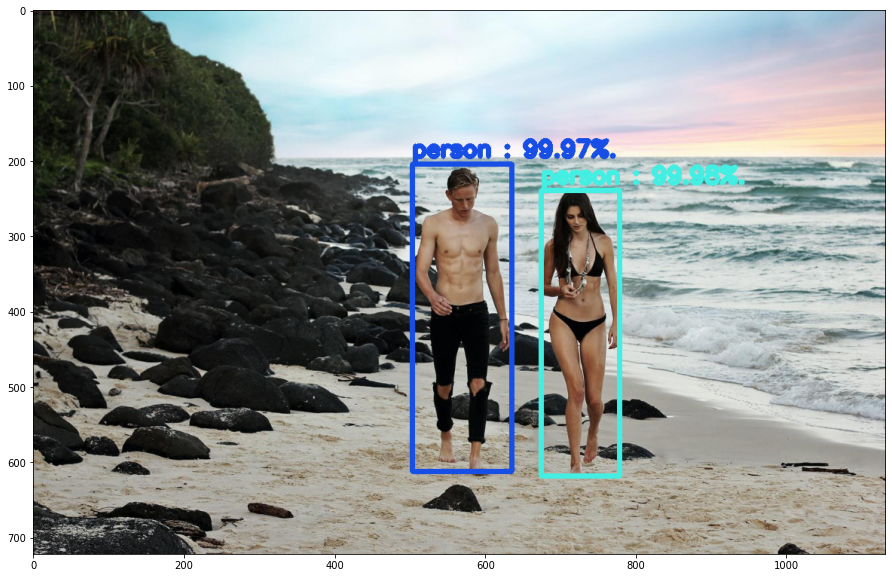

In [25]:
plt.figure(figsize = [20, 10])
plt.imshow(img)
plt.show()

In [19]:
key_model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained = True, progress = True, 
                                                                   num_classes = 2, num_keypoints = 17,
                                                                   pretrained_backbone = True, 
                                                                   trainable_backbone_layers = None)

key_model.eval()

file_path = "Christopher Campbell Unsplash.jpg"

image = load_image(file_path = file_path, scale_factor = 0.75)

print(np.shape(image))

torch.Size([1, 3, 722, 1132])


In [31]:
def get_person_keypoints(model, image, threshold = 0.5):
    with torch.no_grad():
        outputs = model(image)[0]

    _scores = outputs["scores"].detach().numpy()
    _labels = COCO_INSTANCE_CATEGORY_NAMES[outputs["labels"].detach().numpy()]
    want = (_scores > threshold)
    scores = _scores[want].tolist()

    boxes = outputs["boxes"].detach().numpy()[want].tolist()
    labels = _labels[want].tolist()

    keypoints = np.round(outputs["keypoints"].detach().numpy()[want]).astype(int)

    boxes = np.round(boxes).astype(int)
    labels = np.array(labels)
    scores = np.array(scores)
        
    return boxes, labels, scores, keypoints

def draw_keypoints(image, boxes, labels, scores, keypoints, alpha = 1, beta = 0.6, gamma = 0):
    image = image.numpy().squeeze().transpose(1, 2, 0)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    for i in range(len(scores)):
        for j in range(len(keypoints[i])):
            _keypoints = keypoints[i][j]

            if _keypoints[2] == 1:
                cv2.circle(image, (_keypoints[0], _keypoints[1]), radius = 0, color = (0, 0, 255), thickness = 5)

        if len(boxes) > 0:
            cv2.rectangle(image, (boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3]), color = (0, 255, 0), thickness = 5)

        cv2.putText(image , "{:.2f}%.".format(scores[i] * 100), (boxes[i][0], boxes[i][1] - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color = (0, 255, 0), thickness = 5, lineType = cv2.LINE_AA)
    
        image[image > 1] = 1

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [32]:
boxes, labels, scores, keypoints = get_person_keypoints(key_model, image, threshold = 0.8)
img = draw_keypoints(image, boxes, labels, scores, keypoints)

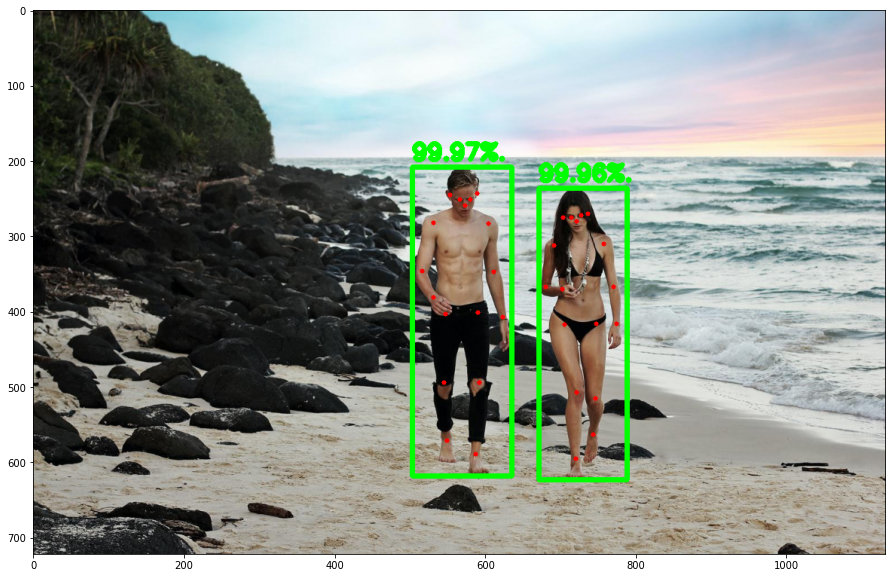

In [33]:
plt.figure(figsize = [20, 10])
plt.imshow(img)
plt.show()